# Filtering a linear system

Here, we define a linear oscillator system where the state is defined as the system's position and velocity. We observe only the position of the system and estimate the complete state using a Kalman filter.

In [ ]:
import torch
import bside
import matplotlib.pyplot as plt

#### Specify problem parameters

In [2]:
dt = 0.01
qc = 0.1
g = 9.81
xdim = 2
ydim = 1
T = 500
r = 0.1
measure_y0 = False
t = torch.linspace(0, T*dt, T+1)

#### Set up the system of interest

In [31]:
x0 = torch.tensor([1.5, 0.])
A_continuous = torch.tensor([[0, 1], [-g, 0]])
A = bside.Matrix(torch.linalg.matrix_exp(A_continuous * dt))
C = bside.Matrix(torch.tensor([[1., 0.]])) # measure only position
Q = bside.PSDMatrix(torch.tensor([[qc * dt**3 / 3, qc * dt**2 / 2], [qc * dt**2 / 2, qc * dt]]))
R = bside.PSDMatrix(torch.tensor([[r**2]]))

dynamics = bside.LinearModel(A)
measurement = bside.LinearModel(C)

dynamics_model = bside.LinearGaussianModel(
    model = dynamics,
    noise_cov = Q    
)
        
observation_model = bside.LinearGaussianModel(
    model = measurement,
    noise_cov = R
)

sys = bside.SSM(
    xdim = xdim,
    ydim = ydim,
    dynamics = dynamics_model,
    observations = observation_model
)

#### Generate and visualize data

In [4]:
x_true, y = sys.measure(x=x0, T=T, keep_y0=measure_y0, return_x=True)
data = bside.Data(y=y, u=None)

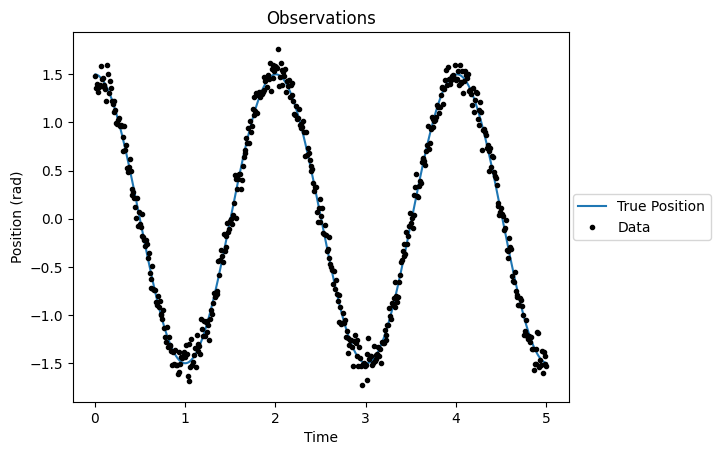

In [17]:
plt.figure()
plt.plot(t if measure_y0 else t[1:], x_true[:, 0], label='True Position')
plt.plot(t if measure_y0 else t[1:], y, 'k.', label='Data')
plt.title('Observations')
plt.xlabel('Time')
plt.ylabel('Position (rad)')
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center right')
plt.show()

#### Set up the filter

In [18]:
P0 = bside.PSDMatrix(torch.eye(xdim))
init_dist = bside.FilteringDistribution(x0, P0)
filter = bside.KalmanFilter(model=sys)

#### Perform and visualize filtering

In [30]:
xf = filter.filter(
    data=data, 
    init_dist=init_dist, 
    y0=measure_y0, 
    return_history=True
)
m_filtered, P_filtered = bside.collate_filtering_distributions(xf)

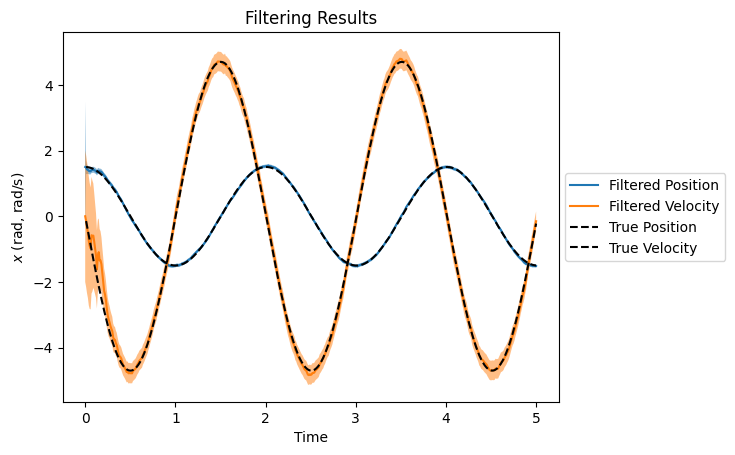

In [33]:
bside.plot_filtering_distributions(m_filtered, P_filtered, t, labels=['Filtered Position', 'Filtered Velocity'])
plt.plot(t[1:], x_true[:, 0], 'k--', label='True Position')
plt.plot(t[1:], x_true[:, 1], 'k--', label='True Velocity')
plt.title('Filtering Results')
plt.xlabel('Time')
plt.ylabel('$x$ (rad, rad/s)')
plt.legend(bbox_to_anchor=(1.35, 0.5), loc='center right')
plt.show()